# CORDEX Regional Climate Projections

...

In [1]:
import geopandas as gpd
import xarray as xr

In [2]:
org_units = gpd.read_file('../test_data/sierra-leone-districts.geojson')
org_units

,type,id,name,hasCoordinatesDown,hasCoordinatesUp,level,grandParentParentGraph,grandParentId,parentGraph,parentId,parentName,dimensions,weight,geometry
0,Polygon,O6uvpzGd5pu,Bo,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,Polygon,fdc6uOvgoji,Bombali,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,MultiPolygon,lc3eMKXaEfw,Bonthe,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,Polygon,jUb8gELQApl,Kailahun,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,MultiPolygon,PMa2VCrupOd,Kambia,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,Polygon,kJq2mPyFEHo,Kenema,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,Polygon,qhqAxPSTUXp,Koinadugu,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Polygon,Vth0fbpFcsO,Kono,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,MultiPolygon,jmIPBj66vD6,Moyamba,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,MultiPolygon,TEQlaapDQoK,Port Loko,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{},1,"MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


In [4]:
# valid variable names
# - "2m_air_temperature",
# - "2m_relative_humidity",
# - "mean_precipitation_flux"

#import earthkit.data
from ecmwf.datastores import Client
import json
import shutil
from pathlib import Path
import time

def model_name_to_stub(name):
    return name.replace('-', '_').lower()

# low emission scenario
africa_rcp_2_6_models = {
    'MOHC-HadGEM2-ES': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
        'ICTP-RegCM4-7',
    ],
    'MPI-M-MPI-ESM-MR': [
        'ICTP-RegCM4-7'
    ],
    'NCC-NorESM1-M': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
        'ICTP-RegCM4-7',
    ],
    'MPI-M-MPI-ESM-LR': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
    ]
}

# medium emission scenario
africa_rcp_4_5_models = {
    'CCCma-CanESM2': [
        'CCCma-CanRCM4',
    ],
}

# high emission scenario
africa_rcp_8_5_models = {
    'CCCma-CanESM2': [
        'CCCma-CanRCM4',
    ],
    'MOHC-HadGEM2-ES': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
        'ICTP-RegCM4-7',
    ],
    'MPI-M-MPI-ESM-MR': [
        'ICTP-RegCM4-7',
    ],
    'NCC-NorESM1-M': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
        'ICTP-RegCM4-7',
    ],
    'MPI-M-MPI-ESM-LR': [
        'CLMcom-KIT-CCLM5-0-15',
        'GERICS-REMO2015',
    ],
}

# lookup table
model_combinations = {
    'africa': {
        'rcp_2_6': africa_rcp_2_6_models,
        'rcp_4_5': africa_rcp_4_5_models,
        'rcp_8_5': africa_rcp_8_5_models,
    }
}

# TODO: rcm 'ICTP-RegCM4-7' uses yearly rather than 5-yearly downloads, need to handle differently... 
skip_rcms = ['ICTP-RegCM4-7']

allowed_start_years = list(range(2006, 2091+1, 5))
allowed_end_years = list(range(2010, 2095+1, 5))

def submit_year_block(client, start_year, end_year, region, save_path, variables, scenario, resolution, gcm_model, rcm_model):
    # construct the query parameters
    params = {
        "domain": region,
        "experiment": scenario,
        "horizontal_resolution": resolution,
        "temporal_resolution": "daily_mean",
        "variable": variables,
        "gcm_model": model_name_to_stub(gcm_model),
        "rcm_model": model_name_to_stub(rcm_model),
        "ensemble_member": "r1i1p1",
        "start_year": [str(start_year)],
        "end_year": [str(end_year)],
        "download_format": "unarchived",
    }

    # download the data
    print(f'Requesting climate projection data from CDS API...')
    print(f'Request parameters: \n{json.dumps(params)}')
    remote = client.submit(
        "projections-cordex-domains-single-levels",
        params
    )

    return remote

def submit(client, start_date, end_date, region, dirname, prefix, variables, scenario, resolution, model_combinations, overwrite=False):
    start_year = int(str(start_date)[:4])
    end_year = int(str(end_date)[:4])
    start_years = [str(y) for y in allowed_start_years if start_year <= y <= end_year]
    end_years = [str(y) for y in allowed_end_years if start_year <= y <= end_year]

    files = []
    request_ids = []
    for gcm_model,rcm_models in model_combinations.items():
        print(f'GCM model {gcm_model}')
        for rcm_model in rcm_models:
            print(f'RCM model {rcm_model}')

            if rcm_model in skip_rcms:
                # HACKY SKIP FOR NOW, SKIP_RCMS IS GLOBAL VARIABLE
                print('Skipping RCM...')
                continue
            
            for start_year, end_year in zip(start_years, end_years):
                print(f'Years {start_year} to {end_year}')
                out_path = Path(dirname).resolve() / f'{prefix}_{gcm_model}_{rcm_model}_{start_year}-{end_year}.nc'
                if overwrite is False and out_path.exists():
                    print('File already exists, reusing from cache', out_path)
                    files.append(out_path)
                    request_ids.append(None)
                    continue
                else:
                    files.append(out_path)
                    remote = submit_year_block(client, start_year, end_year, region, out_path, variables, scenario, resolution, gcm_model, rcm_model)
                    request_ids.append(remote.request_id)

    # return
    results = list(zip(files, request_ids))
    return results

def get(start_date, end_date, region, dirname, prefix, variables, scenario, resolution, model_combinations, overwrite=False):
    # create ecmwf client
    client = Client()
    client.check_authentication()

    # submit or get from cache
    results = submit(client, start_date, end_date, region, dirname, prefix, variables, scenario, resolution, model_combinations, overwrite=overwrite)
    
    # continuously check and collect results
    while True:
        # stop checking if no remaining remotes
        remaining_count = len([filepath for filepath,request_id in results if request_id])
        if remaining_count == 0:
            print('All job requests finished, returning all downloaded files')
            break

        # check any remaining
        print(f'Checking results for {remaining_count} remaining job requests')
        for i in range(len(results)):
            filepath, request_id = results[i]

            if request_id:
                # get latest remote status
                remote = client.get_remote(request_id)

                if remote.results_ready:
                    # download
                    print('Request ready, downloading to', filepath)
                    remote.download(filepath)
                    print('Finished downloading to', filepath)
                    # set remote to None to indicate not one of the remaining
                    results[i] = (filepath, None)

        # take a break before checking again
        time.sleep(5)
    
    # return all local filepaths to user
    filepaths = [filepath for filepath,request_id in results]
    return filepaths

# begin
start_year = 2021
end_year = 2050
dirname = '../test_outputs/cordex'
variables = ['2m_air_temperature']
region = 'africa'
resolution = '0_22_degree_x_0_22_degree'
scenarios = ['rcp_2_6', 'rcp_8_5']

files = []
for scenario in scenarios:
    print('Scenario', scenario)
    prefix = f'cordex_temperature_{scenario}'
    scenario_models = model_combinations['africa'][scenario]
    # scenario_models = {
    #     'MOHC-HadGEM2-ES': [
    #         'CLMcom-KIT-CCLM5-0-15',
    #         'GERICS-REMO2015',
    #         'ICTP-RegCM4-7',
    #     ]
    # }
    subfiles = get(start_year, end_year, region, dirname, prefix, variables, scenario, resolution, scenario_models, overwrite=False)
    print('-->', subfiles)
    files.extend(subfiles)

files

Scenario rcp_2_6
GCM model MOHC-HadGEM2-ES
RCM model CLMcom-KIT-CCLM5-0-15
Years 2021 to 2025
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
Years 2026 to 2030
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
Years 2031 to 2035
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
Years 2036 to 2040
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
Years 2041 to 2045
File already exists, reusing from cache C:\Users\karimba\Documents\Github\dhis2eo\test

[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc'),
 WindowsPath('C:/Users

In [ ]:
# # looks like the files 2030+ were downloaded as zipfiles
# # need to loop through, rename to .zip, and extract nc file using the original filename
# import os
# for fil in os.listdir(dirname):
#     path = os.path.join(dirname, fil)
#     base,ext = os.path.splitext(path)
#     lastyr = base[-4:]
#     if ext == '.nc' and lastyr.isdigit() and int(lastyr) > 2030:
#         zippath = base + '.zip'
#         print(path, '-->', zippath)
#         #shutil.move(path, zippath)

In [ ]:
# import zipfile
# import os
# for fil in os.listdir(dirname):
#     path = os.path.join(dirname, fil)
#     base,ext = os.path.splitext(path)
#     if ext == '.zip':
#         with zipfile.ZipFile(path, 'r') as zip_ref:
#             # Grab the first (and only) member's metadata
#             info = zip_ref.infolist()[0]
            
#             # Rename it in memory
#             origname = info.filename
#             info.filename = base + '.nc'
            
#             # Extract it with the new name
#             print(path, origname, info.filename)
#             #zip_ref.extract(info)

../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015_2031-2035.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015_2036-2040.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015_2041-2045.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_GERICS-REMO2015_2046-2050.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2031-2035.zip
../test_outputs/cordex\cordex_temperature_rcp_2_6_MPI-M-MPI-ESM-LR_CLMcom-KIT-CCLM5-0-15_2036-2040.zip
..

In [36]:
import cftime
import pandas as pd
import numpy as np

def extract_ymdh(t):
    """
    Extract year, month, day, hour from cftime, pandas, or numpy datetime.
    """
    if isinstance(t, cftime.datetime):
        return t.year, t.month, t.day, t.hour

    if isinstance(t, (np.datetime64, pd.Timestamp)):
        ts = pd.Timestamp(t)
        return ts.year, ts.month, ts.day, ts.hour

    raise TypeError(f"Unsupported time type: {type(t)}")

def normalize_calendar(ds, target_cal="365_day"):
    cal = (
        ds.time.encoding.get("calendar")
        or ds.time.attrs.get("calendar")
        or "standard"
    )

    print(f'Converting from calendar {cal} to {target_cal}')

    t0 = ds.time.values[0]
    year, month, day, hour = extract_ymdh(t0)

    norm_time = xr.cftime_range(
        start=cftime.datetime(
            year, month, day, hour, calendar=target_cal
        ),
        periods=ds.sizes["time"],
        freq="D",
        calendar=target_cal,
    )
    numpy_time = norm_time.to_datetimeindex()

    ds = ds.copy()
    ds["time"] = numpy_time
    ds.time.attrs["original_calendar"] = cal
    ds.time.encoding["calendar"] = target_cal

    return ds

# def subset_bbox(ds, xmin, ymin, xmax, ymax):
#     # subset to bbox
#     mask = (
#         (ds.lat >= ymin) & (ds.lat <= ymax) &
#         (ds.lon >= xmin)  & (ds.lon <= xmax)
#     ).compute()

#     ds_subset = ds.where(mask, drop=True)
#     return ds_subset

In [ ]:
# precalc bbox mask
xmin,ymin,xmax,ymax = map(float, org_units.total_bounds)
ds = xr.open_dataset(files[0])
mask = (
    (ds.lat >= ymin) & (ds.lat <= ymax) &
    (ds.lon >= xmin)  & (ds.lon <= xmax)
).compute()

# collect and prep files before concat
datasets = []
for fil in files:
    print('-------->', fil)
    d = xr.open_dataset(fil, chunks={"time": 100})
    # need to normalize slightly different calendar definitions
    d = normalize_calendar(d)
    # make gcm-rcm combo a dimension that we can select on after concat
    gcm = d.model_id
    rcm = d.driving_model_id
    ensemble_id = f'{gcm}__{rcm}'
    d = d.assign_coords(ensemble=ensemble_id) #.expand_dims("ensemble")
    # make scenario a dimension that we can select on after concat
    scenario_id = d.experiment_id
    d = d.assign_coords(scenario=scenario_id) #.expand_dims("scenario")
    # subset to bbox
    subset = d.where(mask, drop=True).compute()
    # add to list
    datasets.append(subset)

In [5]:
datasets[0]

<xarray.Dataset> Size: 7MB
Dimensions:       (scenario: 1, ensemble: 1, rlat: 14, rlon: 13, time: 1800,
                   bnds: 2)
Coordinates:
  * scenario      (scenario) <U5 20B 'rcp26'
  * ensemble      (ensemble) <U38 152B 'CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES'
  * rlat          (rlat) float64 112B 6.93 7.15 7.37 7.59 ... 9.35 9.57 9.79
  * rlon          (rlon) float64 104B -13.09 -12.87 -12.65 ... -10.67 -10.45
  * time          (time) datetime64[ns] 14kB 2021-01-01T12:00:00 ... 2025-12-...
    lon           (rlat, rlon) float64 1kB -13.09 -12.87 ... -10.67 -10.45
    lat           (rlat, rlon) float64 1kB 6.93 6.93 6.93 ... 9.79 9.79 9.79
    height        float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (scenario, ensemble, rlat, rlon) object 1kB b'' b'' ... b''
    tas           (scenario, ensemble, time, rlat, rlon) float32 1MB 300.6 .....
    time_bnds     (scenario, ensemble, time, bnds, rlat, rlon) object 5MB 202...
Attributes: (12/26)
    title:                          CCLMcom-KIT-CCLM5-0-15 model output prepa...
    project_id:                     CORDEX
    CORDEX_domain:                  AFR-22
    driving_model_id:               MOHC-HadGEM2-ES
    experiment_id:                  rcp26
    driving_experiment_name:        rcp26
    ...                             ...
    comment:                        Please use the following reference for th...
    product:                        output
    frequency:                      day
    creation_date:                  2019-11-29-T11:13:21Z
    tracking_id:                    hdl:21.14103/d14daa20-c089-42a4-a605-7650...
    c3s_disclaimer:                 This data has been curated and prepared i...

In [ ]:
# concat
ds = xr.concat(
    datasets, 
    dim="time",
    compat="override",
    coords="minimal",
)
ds

C:\Users\karimba\AppData\Local\Temp\ipykernel_36440\2565802458.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds = xr.concat(
C:\Users\karimba\AppData\Local\Temp\ipykernel_36440\2565802458.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'rlon' ('rlon',) The recommendation is to set join explicitly for this case.
  ds = xr.concat(
C:\Users\karimba\AppData\Local\Temp\ipykernel_36440\2565802458.py:2: FutureWarning: In a future ve

<xarray.Dataset> Size: 6GB
Dimensions:                     (scenario: 2, ensemble: 78, rlat: 14, rlon: 13,
                                 time: 10951, bnds: 2, vertices: 4)
Coordinates:
  * scenario                    (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble                    (ensemble) <U39 12kB 'CLMcom-KIT-CCLM5-0-15__...
  * rlat                        (rlat) float64 112B 6.93 7.15 7.37 ... 9.57 9.79
  * rlon                        (rlon) float64 104B -13.09 -12.87 ... -10.45
  * time                        (time) datetime64[ns] 88kB 2021-01-01T12:00:0...
    lon                         (rlat, rlon) float64 1kB -13.09 ... -10.45
    lat                         (rlat, rlon) float64 1kB 6.93 6.93 ... 9.79 9.79
    height                      float64 8B 2.0
Dimensions without coordinates: bnds, vertices
Data variables:
    rotated_pole                (scenario, ensemble, rlat, rlon) object 227kB ...
    tas                         (scenario, ensemble, time, rlat, rlon) float32 1GB ...
    time_bnds                   (scenario, ensemble, time, bnds, rlat, rlon) object 5GB ...
    rotated_latitude_longitude  (scenario, ensemble, rlat, rlon) float64 227kB ...
    lat_vertices                (scenario, ensemble, rlat, rlon, vertices) float32 454kB ...
    lon_vertices                (scenario, ensemble, rlat, rlon, vertices) float32 454kB ...
Attributes: (12/26)
    title:                          CCLMcom-KIT-CCLM5-0-15 model output prepa...
    project_id:                     CORDEX
    CORDEX_domain:                  AFR-22
    driving_model_id:               MOHC-HadGEM2-ES
    experiment_id:                  rcp26
    driving_experiment_name:        rcp26
    ...                             ...
    comment:                        Please use the following reference for th...
    product:                        output
    frequency:                      day
    creation_date:                  2019-11-29-T11:13:21Z
    tracking_id:                    hdl:21.14103/d14daa20-c089-42a4-a605-7650...
    c3s_disclaimer:                 This data has been curated and prepared i...

In [ ]:
# add ensemble and scenario cords as dims
ds = ds.expand_dims("ensemble").expand_dims("scenario")

In [7]:
# save to disk so can reuse later
ds.drop_vars(['time_bnds']).to_netcdf('../test_outputs/cordex/cordex_temperature_sierra_leone2.nc')

In [3]:
# load from disk
ds = xr.open_dataset('../test_outputs/cordex/cordex_temperature_sierra_leone2.nc')
ds

<xarray.Dataset> Size: 1GB
Dimensions:                     (scenario: 2, ensemble: 78, rlat: 14, rlon: 13,
                                 time: 10951, vertices: 4)
Coordinates:
  * scenario                    (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble                    (ensemble) <U39 12kB 'CLMcom-KIT-CCLM5-0-15__...
  * rlat                        (rlat) float64 112B 6.93 7.15 7.37 ... 9.57 9.79
  * rlon                        (rlon) float64 104B -13.09 -12.87 ... -10.45
  * time                        (time) object 88kB 2021-01-01 12:00:00 ... 20...
    lon                         (rlat, rlon) float64 1kB ...
    lat                         (rlat, rlon) float64 1kB ...
    height                      float64 8B ...
Dimensions without coordinates: vertices
Data variables:
    rotated_pole                (scenario, ensemble, rlat, rlon) |S8 227kB ...
    tas                         (scenario, ensemble, time, rlat, rlon) float32 1GB ...
    rotated_latitude_longitude  (scenario, ensemble, rlat, rlon) float64 227kB ...
    lat_vertices                (scenario, ensemble, rlat, rlon, vertices) float32 454kB ...
    lon_vertices                (scenario, ensemble, rlat, rlon, vertices) float32 454kB ...
Attributes: (12/26)
    title:                          CCLMcom-KIT-CCLM5-0-15 model output prepa...
    project_id:                     CORDEX
    CORDEX_domain:                  AFR-22
    driving_model_id:               MOHC-HadGEM2-ES
    experiment_id:                  rcp26
    driving_experiment_name:        rcp26
    ...                             ...
    comment:                        Please use the following reference for th...
    product:                        output
    frequency:                      day
    creation_date:                  2019-11-29-T11:13:21Z
    tracking_id:                    hdl:21.14103/d14daa20-c089-42a4-a605-7650...
    c3s_disclaimer:                 This data has been curated and prepared i...

In [4]:
# convert to celsius
ds['tas'] = ds.tas - 273.15

In [5]:
ds['time'] = ds.indexes["time"].to_datetimeindex()

C:\Users\karimba\AppData\Local\Temp\ipykernel_25904\2726904630.py:1: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  ds['time'] = ds.indexes["time"].to_datetimeindex()
C:\Users\karimba\AppData\Local\Temp\ipykernel_25904\2726904630.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds.indexes["time"].to_datetimeindex()


In [6]:
# calc ensemble stats for scenarios
rcp_26 = ds.sel(scenario='rcp26')
rcp_26_mean = rcp_26.tas.mean(dim="ensemble")
rcp_26_min = rcp_26.tas.min(dim="ensemble")
rcp_26_max = rcp_26.tas.max(dim="ensemble")
rcp_85 = ds.sel(scenario='rcp85')
rcp_85_mean = rcp_85.tas.mean(dim="ensemble")
rcp_85_min = rcp_85.tas.min(dim="ensemble")
rcp_85_max = rcp_85.tas.max(dim="ensemble")

Stat 24.73433
Stat 25.51466
Stat 26.139145
Stat 24.495218
Stat 26.302307
Stat 27.83495


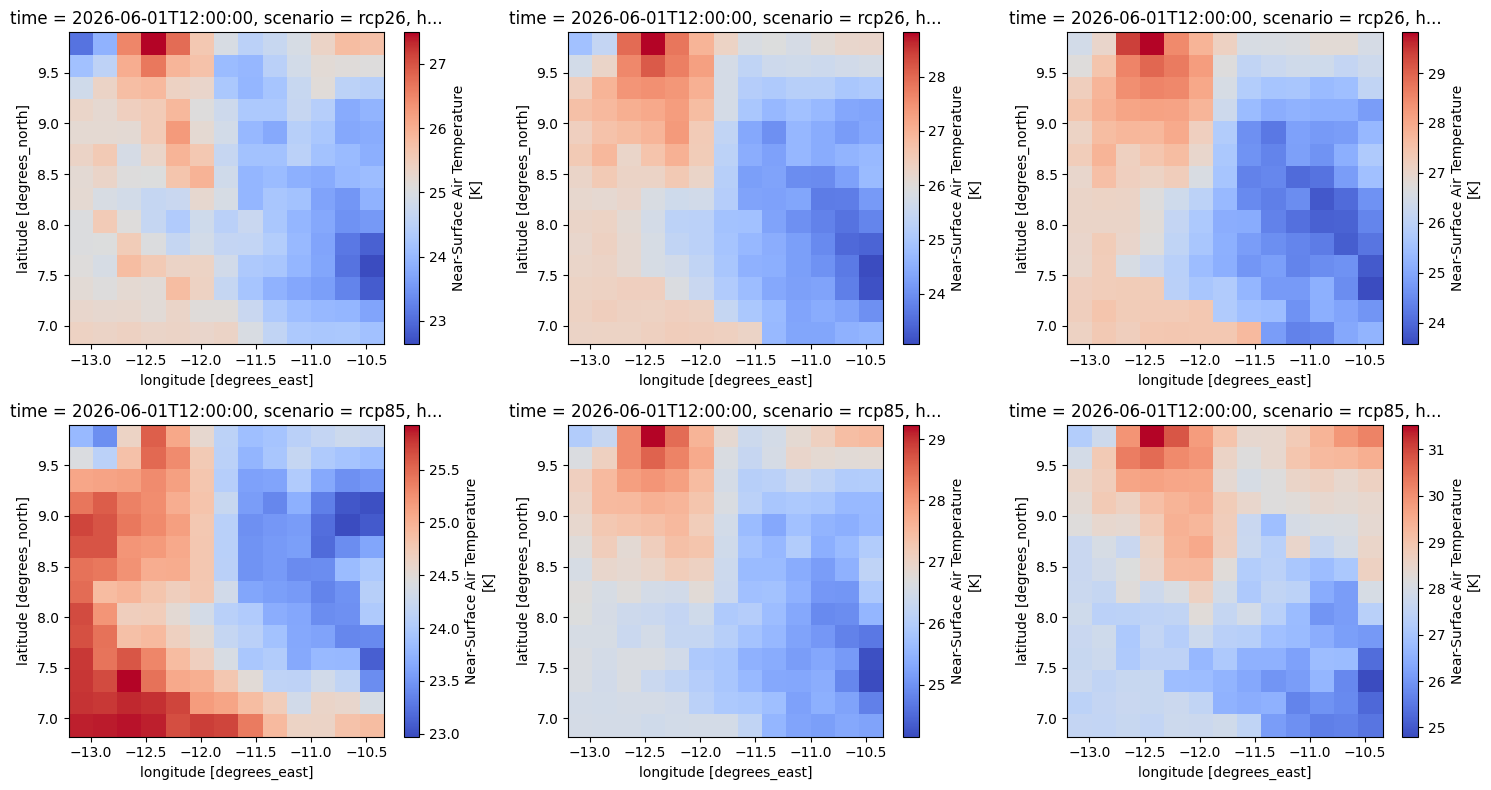

In [12]:
# make multiplot, 1 June 2026

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15,8))

# maps in order min, mean, max
date = '2026-06-01'
vars = [
    rcp_26_min, rcp_26_mean, rcp_26_max,
    rcp_85_min, rcp_85_mean, rcp_85_max,
]
for ax, d in zip(axes.flatten(), vars):
    print('Stat', d.sel(time=date).mean().values)
    d.sel(time=date).plot(ax=ax, x="lon", y="lat", cmap="coolwarm")
    #ax.set_title(stat)

plt.tight_layout()
plt.show()

Stat 25.19887
Stat 25.704966
Stat 26.42378
Stat 26.337324
Stat 27.236511
Stat 28.044884


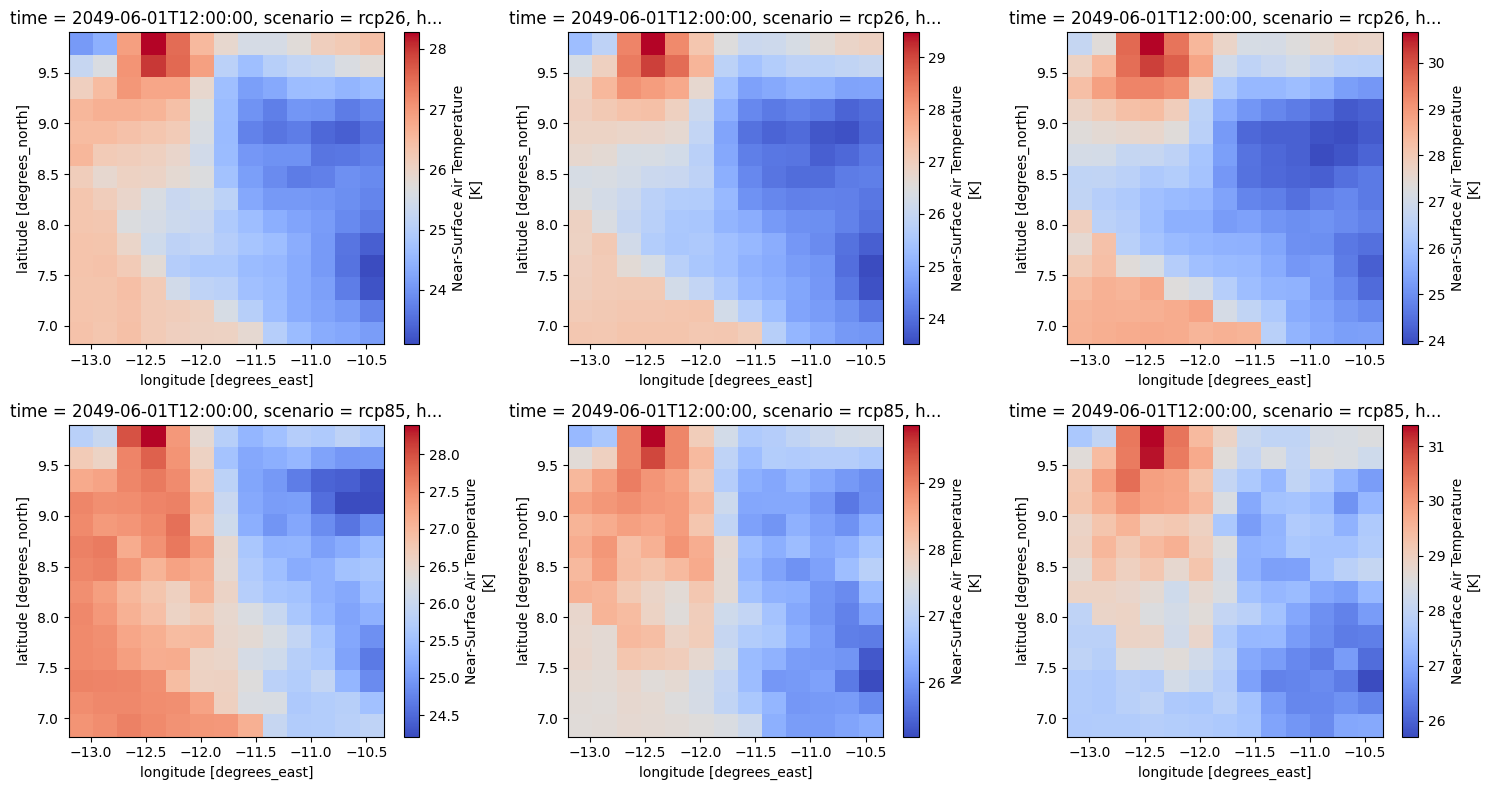

In [14]:
# make multiplot, 1 June 2030

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15,8))

# maps in order min, mean, max
date = '2049-06-01'
vars = [
    rcp_26_min, rcp_26_mean, rcp_26_max,
    rcp_85_min, rcp_85_mean, rcp_85_max,
]
for ax, d in zip(axes.flatten(), vars):
    print('Stat', d.sel(time=date).mean().values)
    d.sel(time=date).plot(ax=ax, x="lon", y="lat", cmap="coolwarm")
    #ax.set_title(stat)

plt.tight_layout()
plt.show()

In [15]:
rcp_26_mean.mean(dim=["rlat","rlon"]).groupby("time.year").count(dim="time").to_dataframe().reset_index()

,year,scenario,height,tas
0,2021,rcp26,2.0,365
1,2022,rcp26,2.0,365
2,2023,rcp26,2.0,365
3,2024,rcp26,2.0,365
4,2025,rcp26,2.0,365
5,2026,rcp26,2.0,365
6,2027,rcp26,2.0,365
7,2028,rcp26,2.0,365
8,2029,rcp26,2.0,365
9,2030,rcp26,2.0,365


In [7]:
# aggregate by year for whole country
rcp_26_mean_yr = rcp_26_mean.resample(time="Y").mean(dim="time").mean(dim=["rlat","rlon"]).compute()
rcp_26_min_yr = rcp_26_min.resample(time="Y").min(dim="time").mean(dim=["rlat","rlon"]).compute()
rcp_26_max_yr = rcp_26_max.resample(time="Y").max(dim="time").mean(dim=["rlat","rlon"]).compute()
rcp_85_mean_yr = rcp_85_mean.resample(time="Y").mean(dim="time").mean(dim=["rlat","rlon"]).compute()
rcp_85_min_yr = rcp_85_min.resample(time="Y").min(dim="time").mean(dim=["rlat","rlon"]).compute()
rcp_85_max_yr = rcp_85_max.resample(time="Y").max(dim="time").mean(dim=["rlat","rlon"]).compute()

c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Loc

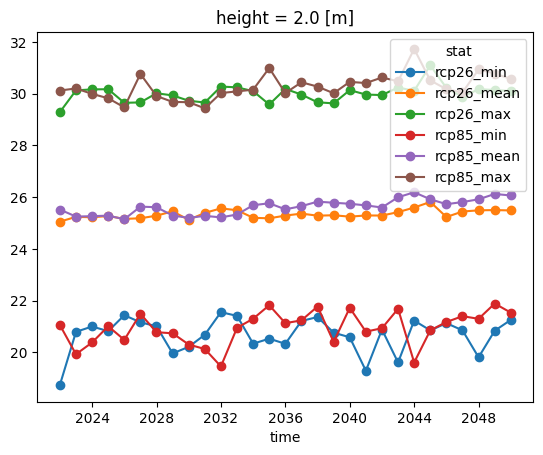

In [8]:
# plot min, mean, max
# should actually be -1 on year values, not sure why
tas_yr = xr.Dataset(
    {
        "rcp26_min": rcp_26_min_yr.drop_vars('scenario'),
        "rcp26_mean": rcp_26_mean_yr.drop_vars('scenario'),
        "rcp26_max": rcp_26_max_yr.drop_vars('scenario'),
        "rcp85_min": rcp_85_min_yr.drop_vars('scenario'),
        "rcp85_mean": rcp_85_mean_yr.drop_vars('scenario'),
        "rcp85_max": rcp_85_max_yr.drop_vars('scenario'),
    }
)
tas_yr.sel(time=slice('2020', '2049')).to_array("stat").plot(x="time", hue="stat", marker="o", linestyle="-")

In [24]:
#rcp_26.groupby('time.year').count(dim="time").to_dataframe().reset_index().query('tas < 10 & tas > 0')
rcp_26_ens_yr_mean = rcp_26.resample(time="Y").mean(dim="time").mean(dim=["rlat","rlon"]).compute()
rcp_26_ens_yr_mean

c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 119kB
Dimensions:                     (time: 31, ensemble: 78, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 248B 2021-12-31 ... 205...
  * ensemble                    (ensemble) <U39 12kB 'CLMcom-KIT-CCLM5-0-15__...
    scenario                    <U5 20B 'rcp26'
    height                      float64 8B 2.0
Dimensions without coordinates: vertices
Data variables:
    tas                         (time, ensemble) float32 10kB 25.51 nan ... nan
    rotated_latitude_longitude  (time, ensemble) float64 19kB nan nan ... nan
    lat_vertices                (time, ensemble, vertices) float32 39kB nan ....
    lon_vertices                (time, ensemble, vertices) float32 39kB nan ....
Attributes: (12/26)
    title:                          CCLMcom-KIT-CCLM5-0-15 model output prepa...
    project_id:                     CORDEX
    CORDEX_domain:                  AFR-22
    driving_model_id:               MOHC-HadGEM2-ES
    experiment_id:                  rcp26
    driving_experiment_name:        rcp26
    ...                             ...
    comment:                        Please use the following reference for th...
    product:                        output
    frequency:                      day
    creation_date:                  2019-11-29-T11:13:21Z
    tracking_id:                    hdl:21.14103/d14daa20-c089-42a4-a605-7650...
    c3s_disclaimer:                 This data has been curated and prepared i...

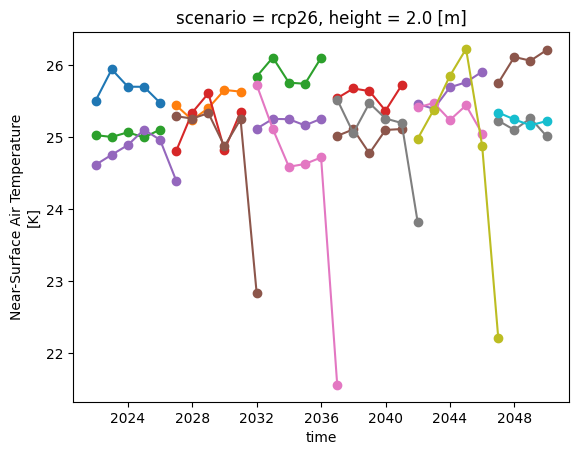

In [30]:
rcp_26_ens_yr_mean.tas.sel(time=slice('2020', '2049')).plot(x="time", hue="ensemble", marker="o", linestyle="-", add_legend=False)

In [29]:
rcp_26_ens_yr_mean.tas.sel(ensemble='CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES', time=slice('2020', '2049')).to_dataframe().reset_index().head(100)

,time,ensemble,scenario,height,tas
0,2021-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,25.507858
1,2021-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN
2,2021-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN
3,2021-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN
4,2021-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN
...,...,...,...,...,...
95,2028-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN
96,2029-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN
97,2029-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,25.656849
98,2029-12-31,CLMcom-KIT-CCLM5-0-15__MOHC-HadGEM2-ES,rcp26,2.0,NaN


----

## Hmmm

New approach something weird happened when merging the different datasets...

It seems the calendar conversion per file creates some issues with too few dates in a year, or dates that spill over into another year dragging down the year stats, etc. 

Correcting this here by aggregating to months where calendars dont matter. 

In [45]:
files

[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/cordex/cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc'),
 WindowsPath('C:/Users

In [127]:
import pandas as pd

# precalc bbox
xmin,ymin,xmax,ymax = map(float, org_units.total_bounds)

# collect and prep files before concat
datasets = []
for fil in files:
    # if not \
    #     ('rcp_8_5_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021' in str(fil) or \
    #     'rcp_8_5_MOHC-HadGEM2-ES_GERICS-REMO2015_2021' in str(fil) \
    #     ):
    #     continue
    
    # open dataset
    print('-------->', fil)
    d = xr.open_dataset(fil, chunks={"time": 500}) #, "rlat": 100, "rlon": 100})

    # fix datasets with lon 0-360
    if d.lon.max() > 180:
        lon = ((d.lon + 180) % 360) - 180
        d = d.assign_coords(lon=lon)
        print('longitude coordinates converted from 0 to 360, to -180 to 180')
    
    # subset to bbox
    mask = (
        (d.lat >= ymin) & (d.lat <= ymax) &
        (d.lon >= xmin)  & (d.lon <= xmax)
    ).compute()
    subset = d.where(mask, drop=True).compute()
    
    # need to aggregate to months
    grouped = subset['tas'].resample(time="MS", skipna=True)
    monthly = xr.Dataset({
        "tas_mean": grouped.mean(dim="time"),
        "tas_min": grouped.min(dim="time"),
        "tas_max": grouped.max(dim="time"),
    })

    # convert to numpy datetime after aggregating to months
    #if hasattr(monthly.indexes["time"], 'to_datetimeindex'):
    #    monthly['time'] = monthly.indexes["time"].to_datetimeindex()
    if hasattr(monthly.indexes["time"], 'to_datetimeindex'):
        time = pd.DatetimeIndex([
            pd.Timestamp(t.year, t.month, 1) for t in monthly.time.values
        ])
        monthly = monthly.assign_coords(time=time)
    else:
        print('time dim already in numpy datetime format')
    
    # make gcm-rcm combo a dimension that we can select on after concat
    gcm = d.model_id
    rcm = d.driving_model_id
    ensemble_id = f'{gcm}__{rcm}'
    monthly = monthly.assign_coords(ensemble=ensemble_id).expand_dims("ensemble")
    
    # make scenario a dimension that we can select on after concat
    scenario_id = d.experiment_id
    monthly = monthly.assign_coords(scenario=scenario_id).expand_dims("scenario")
    
    # add to list
    datasets.append(monthly)

--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2021-2025.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2026-2030.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2031-2035.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2036-2040.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2041-2045.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\cordex\cordex_temperature_rcp_2_6_MOHC-HadGEM2-ES_CLMcom-KIT-CCLM5-0-15_2046-2050.nc
--------> C:\Users\karimba\Documents\Github\dhis2eo\tests\test_o

In [128]:
# concat
ds = xr.combine_by_coords(
    datasets, 
    combine_attrs="override",
)
ds

C:\Users\karimba\AppData\Local\Temp\ipykernel_28100\1204837539.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'rlon' ('rlon',) The recommendation is to set join explicitly for this case.
  ds = xr.combine_by_coords(
C:\Users\karimba\AppData\Local\Temp\ipykernel_28100\1204837539.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'rlat' ('rlat',) The recommendation is to set join explicitly for this case.
  ds = xr.combine_by_coords(
C:\Users\karimba\AppData\Local\Temp\ipykernel_28100\1204837539.py:2: FutureW

<xarray.Dataset> Size: 97MB
Dimensions:   (scenario: 2, ensemble: 7, time: 360, rlat: 41, rlon: 39)
Coordinates:
  * scenario  (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble  (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERICS-...
  * time      (time) datetime64[ns] 3kB 2021-01-01 2021-02-01 ... 2050-12-01
  * rlat      (rlat) float64 328B 6.93 6.93 6.93 7.15 ... 9.57 9.79 9.79 9.79
  * rlon      (rlon) float64 312B -13.09 -13.09 -13.09 ... -10.45 -10.45 -10.45
    lon       (rlat, rlon) float64 13kB -13.09 nan nan nan ... nan nan -10.45
    lat       (rlat, rlon) float64 13kB 6.93 nan nan nan ... 9.79 nan nan 9.79
    height    float64 8B 2.0
Data variables:
    tas_mean  (scenario, ensemble, time, rlat, rlon) float32 32MB nan ... nan
    tas_min   (scenario, ensemble, time, rlat, rlon) float32 32MB nan ... nan
    tas_max   (scenario, ensemble, time, rlat, rlon) float32 32MB nan ... nan

In [129]:
# save to disk so can reuse later
ds.to_netcdf('../test_outputs/cordex/cordex_temperature_sierra_leone3.nc')

In [130]:
# open from disk
ds = xr.open_dataset('../test_outputs/cordex/cordex_temperature_sierra_leone3.nc')

In [131]:
# convert to kelvin
ds = ds - 273.15
ds

<xarray.Dataset> Size: 97MB
Dimensions:   (rlon: 39, rlat: 41, time: 360, scenario: 2, ensemble: 7)
Coordinates:
  * rlon      (rlon) float64 312B -13.09 -13.09 -13.09 ... -10.45 -10.45 -10.45
  * rlat      (rlat) float64 328B 6.93 6.93 6.93 7.15 ... 9.57 9.79 9.79 9.79
  * time      (time) datetime64[ns] 3kB 2021-01-01 2021-02-01 ... 2050-12-01
  * scenario  (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble  (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERICS-...
    lon       (rlat, rlon) float64 13kB ...
    lat       (rlat, rlon) float64 13kB ...
    height    float64 8B ...
Data variables:
    tas_mean  (scenario, ensemble, time, rlat, rlon) float32 32MB nan ... nan
    tas_min   (scenario, ensemble, time, rlat, rlon) float32 32MB nan ... nan
    tas_max   (scenario, ensemble, time, rlat, rlon) float32 32MB nan ... nan

In [132]:
# aggregate to entire country
monthly = ds.mean(dim=["rlat","rlon"])
monthly

<xarray.Dataset> Size: 64kB
Dimensions:   (time: 360, scenario: 2, ensemble: 7)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2021-01-01 2021-02-01 ... 2050-12-01
  * scenario  (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble  (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERICS-...
    height    float64 8B ...
Data variables:
    tas_mean  (scenario, ensemble, time) float32 20kB nan nan ... 27.47 25.76
    tas_min   (scenario, ensemble, time) float32 20kB nan nan ... 25.41 24.02
    tas_max   (scenario, ensemble, time) float32 20kB nan nan ... 29.08 27.71

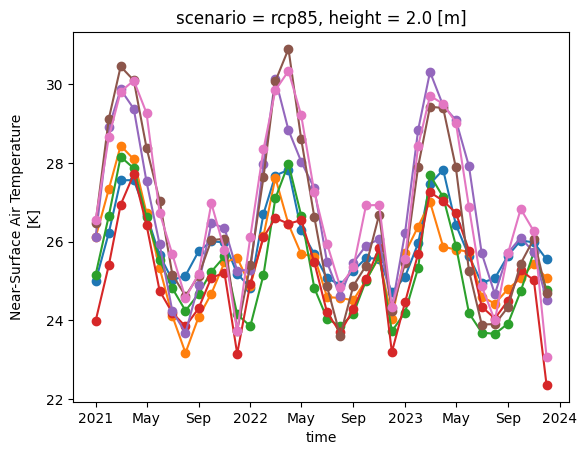

In [ ]:
# plot monthly ensemble
monthly['tas_mean'].sel(scenario='rcp85', time=slice(None, '2023')).plot(x="time", hue='ensemble', marker="o", linestyle="-", add_legend=False)

In [137]:
# aggregate to years
yearly = xr.Dataset({
    "tas_mean": monthly['tas_mean'].resample(time="Y", skipna=True).mean(dim="time"),
    "tas_min": monthly['tas_min'].resample(time="Y", skipna=True).min(dim="time"),
    "tas_max": monthly['tas_max'].resample(time="Y", skipna=True).max(dim="time"),
})
yearly

c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
c:\Users\karimba\AppData\Local\miniconda3\envs\climate-tools-py313\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 6kB
Dimensions:   (scenario: 2, ensemble: 7, time: 30)
Coordinates:
  * scenario  (scenario) <U5 40B 'rcp26' 'rcp85'
  * ensemble  (ensemble) <U39 1kB 'CCCma-CanRCM4__CCCma-CanESM2' ... 'GERICS-...
  * time      (time) datetime64[ns] 240B 2021-12-31 2022-12-31 ... 2050-12-31
    height    float64 8B 2.0
Data variables:
    tas_mean  (scenario, ensemble, time) float32 2kB nan nan nan ... 27.5 27.75
    tas_min   (scenario, ensemble, time) float32 2kB nan nan nan ... 22.85 23.77
    tas_max   (scenario, ensemble, time) float32 2kB nan nan nan ... 31.73 32.39

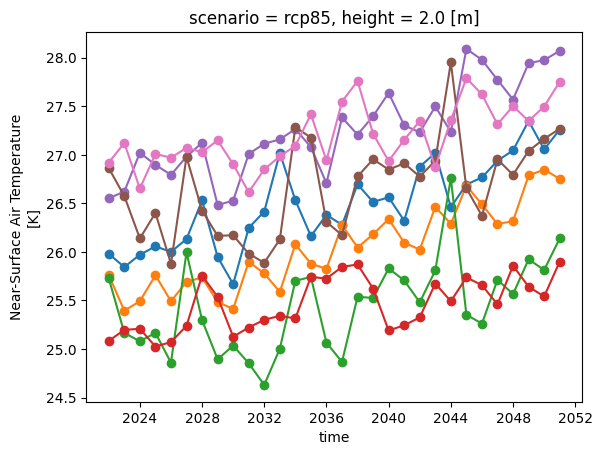

In [148]:
# plot yearly ensemble
#yearly.to_array("stat").plot(x="time", hue="stat", marker="o", linestyle="-")
yearly['tas_mean'].sel(scenario='rcp85').plot(x="time", hue="ensemble", marker="o", linestyle="-", add_legend=False)

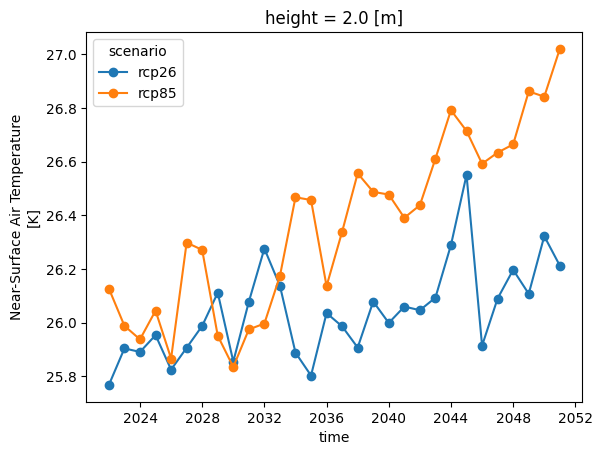

In [150]:
# compare rcp26 vs 85 ensemble mean
yearly['tas_mean'].mean(dim='ensemble').plot(x="time", hue="scenario", marker="o", linestyle="-")

Everything good up until this point. It seems merging different models leads to some duplicates and slight coordinate differences, leading to mapping difficulties. 

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

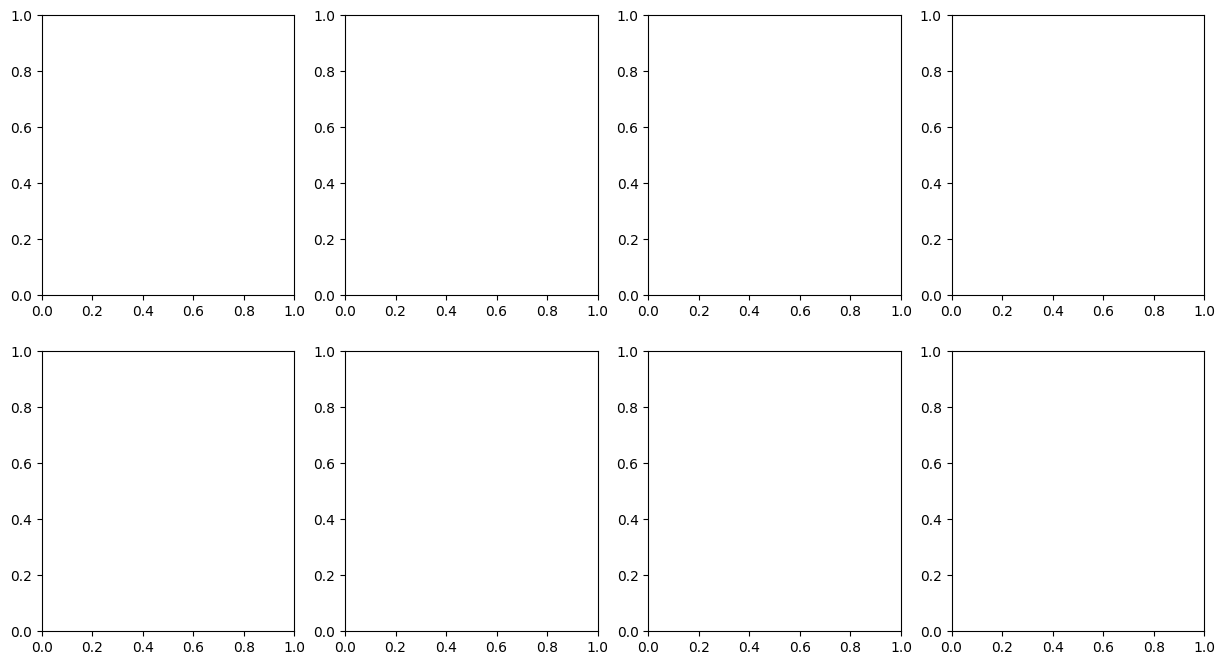

In [167]:
# and a quick map comparison across scenarios and decades

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 4, figsize=(15,8))

# maps
valid_coords = np.isfinite(ds.lon) & np.isfinite(ds.lat)
monthly_low = ds.sel(scenario='rcp26').mean(dim='ensemble')
monthly_high = ds.sel(scenario='rcp85').mean(dim='ensemble')
dates = ['2021-03', '2030-03', '2040-03', '2050-03']
vars = [
    monthly_low.sel(time=dt) for dt in dates
]
vars += [
    monthly_high.sel(time=dt) for dt in dates
]
for ax, d in zip(axes.flatten(), vars):
    #print('Stat', d.mean().values)
    d['tas_mean'].where(valid_coords, drop=True).plot(ax=ax, x="lon", y="lat", cmap="coolwarm")
    #ax.set_title(stat)

plt.tight_layout()
plt.show()

In [179]:
d.rlon #lon.isel(rlat=0)

<xarray.DataArray 'rlon' (rlon: 39)> Size: 312B
array([-13.09    , -13.09    , -13.089996, -12.87    , -12.87    , -12.869995,
       -12.650009, -12.65    , -12.65    , -12.43    , -12.43    , -12.429993,
       -12.21    , -12.21    , -12.209991, -11.99    , -11.99    , -11.98999 ,
       -11.770004, -11.77    , -11.77    , -11.550003, -11.55    , -11.55    ,
       -11.33    , -11.33    , -11.329987, -11.110016, -11.11    , -11.11    ,
       -10.89    , -10.89    , -10.889999, -10.67    , -10.67    , -10.669998,
       -10.45    , -10.45    , -10.449997])
Coordinates:
  * rlon      (rlon) float64 312B -13.09 -13.09 -13.09 ... -10.45 -10.45 -10.45
    scenario  <U5 20B 'rcp26'
    height    float64 8B ...
Attributes:
    long_name:      longitude in rotated pole grid
    units:          degrees
    axis:           X
    standard_name:  grid_longitude

In [169]:
d['tas_mean'].sel(
    lon=d.lon[np.isfinite(d.lon)],
    lat=d.lat[np.isfinite(d.lat)]
)

IndexError: 2-dimensional boolean indexing is not supported. 